# Modélisation 3 : modèle Seq2Seq

## Introduction

Dans l'itération précédente, nous avions étudié un modèle d'Embedding fournissant une traduction mot à mot. Nous avions constaté que ce système avait ses limites car il ne prenait pas en compte le contexte des mots dans une phrase. 

Dans cette itération, nous avons utilisé un modèle Seq2Seq en incorporant un mécanisme d'attention.  Ce type de modèle permet de travailler sur des phrases entières et donc de prendre en compte le contexte. 

Nous avons travaillé sur le "premier" jeu de données fourni, à savoir un ensemble de phrases identiques traduites en français et en anglais. Pour mémoire, ce jeu de données comprend environ 130 000 phrases pour un nombre de mots uniques assez faible (environ 200-300 mots par langue). 

## Pré-traitement des données

In [58]:
# Import des packages
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN, Lambda, Embedding

import unicodedata
import re
import os
import io
import time

import random

# -*- coding: utf-8 -*-

In [59]:
# Importation des données 
data = pd.read_csv("small_vocab_fr-eng.csv", sep = ';')

# Suppression des doublons 
data.drop_duplicates(inplace = True)
data.reset_index(inplace = True, drop = True)

#data.tail()

In [60]:
# Nettoyage des données 

# Fonction de conversion d'un document d'unicode vers ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Prétraitement des phrases
def clean_sentence(w):
   
    # conversion unicode vers ascii
    w = unicode_to_ascii(w.lower().strip())

    # séparation entre un mot et sa ponctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # remplacement de caractères spéciaux par un espace
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()

    # ajout des balises <start> et <end> placées respectivement au début et à la fin des phrases
    w = '<start> ' + w + ' <end>'
    
    return w

# Appliquer la fonction clean_sentence sur la colonne english
data.English = data.English.apply(lambda x: clean_sentence(x))

# Appliquer la fonction clean_sentence sur la colonne french
data.Français = data.Français.apply(lambda x: clean_sentence(x))

# Visulisation des 5 premières lignes
data.head()

,Français,English
0,<start> new jersey est parfois calme pendant l...,<start> new jersey is sometimes quiet during a...
1,<start> les etats unis est generalement froid ...,<start> the united states is usually chilly du...
2,<start> california est generalement calme en m...,<start> california is usually quiet during mar...
3,<start> les etats unis est parfois legere en j...,<start> the united states is sometimes mild du...
4,"<start> votre moins aime fruit est le raisin ,...","<start> your least liked fruit is the grape , ..."


In [66]:
# Structuration des données 

def tokenize(sentences):
    # tokenization des phrases
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)

    # transformation des phrases en séquences
    seq = tokenizer.texts_to_sequences(sentences)
    
    # complète les séquences de sorte à ce qu'ils aient la même longueur
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq,padding='post')

    # post : le padding est réalisé à la fin des séquences
    return seq, tokenizer

# Tokenization(transforme une phrase en une liste de nombres qui correspondent chacun à un mot unique du vocabulaire)
input_seq, input_tokenizer = tokenize(data.English) # phrases tokenisées en fonction du vocabulaire anglais  
target_seq, target_tokenizer = tokenize(data.Français) # phrases tokenisées en fonction du vocabulaire français 
# input_tokenizer: est le tokenizer entraîné sur le jeu de données des phrases anglaises

# Calcul de la taille des vocabulaires via l'attribut .word_index qui transforme l'index d'un mot en sa chaîne de caractères 
vocab_size_inp = len(input_tokenizer.word_index)+1 # nombre de mots différents en français 
vocab_size_targ = len(target_tokenizer.word_index)+1 # nombre de mots différents en anglais 

# Calcul de longeur maximale des séquences 
max_length_inp, max_length_targ = input_seq.shape[1], target_seq.shape[1] 

print("Taille du vocabulaire :")
print(" - input :", vocab_size_inp)
print(" - target :", vocab_size_targ)

Taille du vocabulaire :
 - input : 206
 - target : 331


## Entraînement du modèle

In [5]:
# Séparation des données en un ensemble d'apprentissage et de test

# Création des ensembles d'apprentissage et test
X_train, X_test, y_train, y_test = train_test_split(input_seq, target_seq,test_size=0.2)

# Paramètres de l'entrainement
# buffer_size: permet de déterminer combien d'éléments vont être mélangés au fur et à mesure, 
# commme la BDD est importante 103 339 phrases -> divisé par 5
# batch_size: sépare dans l'ordre le dataset en jeux de données de dimension fixe
batch_size = 80 
buffer_size = int(len(X_train)/5) 
steps_per_epoch = buffer_size//batch_size

# Création du dataset d'entrainement
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

# Affichage des deux composantes d'un jeu de données
example_input_batch, example_target_batch = next(iter(dataset))
print("Dimensions du batch input : ", example_input_batch.shape)
print("Dimensions du batch target : ", example_target_batch.shape)

Dimensions du batch input :  (80, 19)
Dimensions du batch target :  (80, 25)


## Modèle sélectionné

Le modèle Seq2Seq se base sur une architecture de RNN (réseaux de neurones récurrents) avec un encodeur et un décodeur. 

Ce système permet de "lire" les phrases avec l'Encodeur pour dégager une signification globale, transcrite mathématiquement sous la forme d'un vecteur "sens". Le modèle traite ensuite ce vecteur pour procéder à la traduction via le Décodeur. 

A ce modèle de base Seq2Seq, nous rajouté un mécanisme d'attention qui permet de conserver un maximum d'information sur la séquence source et son contexte. Concrètement, cela se traduit par la construction successive de 2 vecteurs principaux (vecteur d'alignement et vecteur contexte). 

Le vecteur d'alignement aura la même longueur que la séquence source, chacune de ses valeurs est le score (ou la probabilité) que le mot corresponde à celui de la séquence source. 

Le vecteur de contexte est utilisé comme inputs par le Décodeur. Il s’agit de la moyenne pondérée de la sortie de l’Encodeur. Il est obtenu en réalisant le produit scalaire du vecteur d'alignement et de la sortie de l’Encodeur.

Nous avons sélectionné un modèle Keras avec les spécificités suivantes: 
- système bidirectionnel 
- 2 couches (une couche Embedding et une couche RNN) 
- un type de cellule GRU (gated recurrent unit) avec 512 neurones

### Encodeur 

Nous avons sélectionné un encodeur avec une couche embedding avec une matrice de dimension 300 et une couche GRU (gated recurrent unit) avec 512 neurones. 

In [6]:
# Définition de l'encodeur 

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, latent_dim):
        # vocab_size: taille du vocabulaire dans la langue de départ
        # embedding_dim: dimension de la matrice d'embedding 
        # latent_dim : dimension de l'état caché (units)
        
        super(Encoder, self).__init__() # pour faciliter des questions d'héritage 
        
        self.units = latent_dim
        
        # sélection de l'embedding, fonction qui permet de vectoriser les mots représentés précédemment par leur index 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # sélection de la cellule de calcul GRU 
        self.gru = tf.keras.layers.GRU(self.units, # nombre d'états cachés - neurones  
                                       return_sequences=True, # retourne une séquence/ bidirectionelle
                                       return_state=True, # permet de conserver la mémoire de l'encodeur et le rend disponible pour le décodeur 
                                       recurrent_initializer='glorot_uniform') # initialisation des poids de la matrice utilisée pour la transformation linéaire des états récurrents par distribution uniforme 
      
    def call(self, x, hidden): # calcul des sorties du modèle 
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.units)) # définition d'une matrice de dim jeu de données fixé * nombre d'états cachés 


# Paramètres du modèle

latent_dim = 512 # nombre d'états cachés (2 puissance 9)
embedding_dim = 300 # dimension de la matrice d'embedding

encoder = Encoder(vocab_size_inp, embedding_dim, latent_dim)

hidden = encoder.initialize_hidden_state(batch_size) # état caché
enc_output, hidden = encoder(example_input_batch, hidden) # sortie

print('Dimensions de la sortie de l\'Encodeur : ')
print(' (batch size, max_length_inp, latent_dim) -> {}'.format(enc_output.shape))
print()

print('Dimensions de l\'état caché :')
print(' (batch size, latent_dim) -> {}'.format(hidden.shape))

Dimensions de la sortie de l'Encodeur : 
 (batch size, max_length_inp, latent_dim) -> (80, 19, 512)

Dimensions de l'état caché :
 (batch size, latent_dim) -> (80, 512)


### Mécanisme d'attention 

In [7]:
# définition de la classe 

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # définition de 3 couches de neuronnes denses 
        self.W1 = tf.keras.layers.Dense(units)# couche de l'état caché 
        self.W2 = tf.keras.layers.Dense(units) # couche de sortie de l'encodeur
        self.V = tf.keras.layers.Dense(1) # couche de sortie du mécanisme d'attention  

    def call(self, hidden, enc_output):
        # dimensions de 'hidden' : (batch_size, units)
        # dimensions de 'enc_output' : (batch_size, max_length_input, units)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # dimensions de 'hidden_with_time_axis' : (batch_size, 1, units)
        # ce changement de dimension est nécessaire pour le calcul du score
        
        # Application de la formule score = FC(tanh(FC(EO) + FC(H))
        # avec FC: couche Fully-connected (dense layer) c'est-à-dire W1 et W2
        # EO: sortie de l’Encodeur, encoder_output 
        # H : état caché, hidden_state. 

        score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(enc_output)))
        # dimensions de 'score' : (batch_size, max_length_inp, 1)
        # dimensions avant d'appliquer 'self.V' : (batch_size, max_length_inp, units)

        # calcul des poids d'attention via la fonction softmax 
        attention_weights = tf.nn.softmax(score, axis=1)
        # dimensions de 'attention_weights' : (batch_size, max_length_inp, 1)
        
        # calcul du vecteur contexte par produit scalaire
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # dimensions de context_vector après somme (batch_size, units)

        return context_vector, attention_weights

# paramétrage

attention_layer = BahdanauAttention(latent_dim)
attention_result, attention_weights = attention_layer(hidden, enc_output)

print("Dimensions de la sortie de la couche d'attention :")
print(" (batch size, latent_dim) {}".format(attention_result.shape))
print("Dimensions des poids d'attention :")
print(" (batch_size, max_length_inp, 1) {}".format(attention_weights.shape))


Dimensions de la sortie de la couche d'attention :
 (batch size, latent_dim) (80, 512)
Dimensions des poids d'attention :
 (batch_size, max_length_inp, 1) (80, 19, 1)


### Décodeur 

Le décodeur est constitué des mêmes couches que l'Encodeur avec la notion d'attention ajoutée. 

In [8]:
# Définition du décodeur 


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, latent_dim, attention_layer):
        # même architecture que l'encodeur
        super(Decoder, self).__init__()
        
        self.units = latent_dim
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        # couche dense comprenant le vocabulaire de la langue cible 
        self.fc = tf.keras.layers.Dense(vocab_size)

        # prise en compte de la notion d'attention en input du décodeur 
        self.attention = attention_layer(latent_dim)

    def call(self, x, hidden, enc_output):
        # dimensions de 'enc_output' : (batch_size, max_length_inp, latent_dim)
        
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # dimensions de 'context_vector' : (batch size, latent_dim)
        # dimensions de 'attention_weights' : (batch_size, max_length_inp, 1)

        x = self.embedding(x)
        # dimensions de 'x' : (batch_size, 1, embedding_dim)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # dimensions de 'x' : (batch_size, 1, embedding_dim + latent_dim)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        # dimensions de 'output' : (batch_size * 1, latent_dim )

        output = self.fc(output)
        # dimensions de 'output' : (batch_size, vocab)

        return output, state, attention_weights

# paramétrage 

decoder = Decoder(vocab_size_targ, embedding_dim, latent_dim, BahdanauAttention)

dec_input = tf.random.uniform((batch_size, 1))
dec_output, _, _ = decoder(dec_input, hidden, enc_output)

print ('Dimension de la sortie du Décodeur :')
print(' (batch_size, vocab size) -> {}'.format(dec_output.shape))

Dimension de la sortie du Décodeur :
 (batch_size, vocab size) -> (80, 331)


### Fonction de coût et optimiseur 

In [9]:
# Fonction de coût et optimiseur

def loss_function(real, pred):
    # calcul de l'entropie croisée à partir de la fonction logits entre la valeur réelle et la valeur prédite  
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0)) 
    # masque de même taille que la séquence, qui contient 0 si la valeur de l'élement de la séquence est nulle, 1 sinon
    # ce masque permet de contrer l'effet du padding sur la fonction loss
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask # application de ce masque comme poids lors du calcul de l'erreur 
    return tf.reduce_mean(loss_)

optimizer = tf.keras.optimizers.Adam() # application de la méthode d'optimisation réalisée à partir de la fonction Adam 

## Entrainement du modèle 

In [10]:
# Entrainement du modèle 

@tf.function
def train_step(inp, targ, enc_initial_hidden):
    
    loss = 0 # initisalisation de la perte
    
    # utilisation d'une fonction de perte de Gradient 
    with tf.GradientTape() as tape:
        
        enc_output, enc_hidden = encoder(inp, enc_initial_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * batch_size, 1)

        # parcours de chaque élement de 'targ'
        for t in range(1, targ.shape[1]):
            
            # appel au Décodeur
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            # calcul de la perte
            loss += loss_function(targ[:, t], predictions)

            # mise à jour de la variable 'dec_input'
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        
        # calcul des variables du modèle
        variables = encoder.trainable_variables + decoder.trainable_variables
    #calcul du gradient du modèle
    gradients = tape.gradient(loss, variables)
    # optimisation des variables du modèle
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [11]:
# Evaluation des performances pendant l'entrainement du modèle 
# avec suivi de la fonction de perte tous les 100 batchs dans chaque époque

# Checkpoint - permet d'enregistrer le modèle
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

def train(n_epoch = 10):

    t=time.time()

    for epoch in range(n_epoch):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state(batch_size)
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))

        # conservation du modèle tout les 2 epochs
        # if (epoch + 1) % 2 == 0:
            # checkpoint.save(file_prefix = checkpoint_prefix)
        
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))

        print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))


    print("Time elapsed :{}s".format(round(time.time() - t,2)))

train(n_epoch = 10)


Epoch 1 Batch 0 Loss 3.6892
Epoch 1 Batch 100 Loss 0.9740
Epoch 1 Batch 200 Loss 0.7589
Epoch 1 Loss 1.2163
Time taken for 1 epoch 439.59 sec

Epoch 2 Batch 0 Loss 0.6874
Epoch 2 Batch 100 Loss 0.6217
Epoch 2 Batch 200 Loss 0.5128
Epoch 2 Loss 0.5859
Time taken for 1 epoch 391.17 sec

Epoch 3 Batch 0 Loss 0.4697
Epoch 3 Batch 100 Loss 0.4215
Epoch 3 Batch 200 Loss 0.3426
Epoch 3 Loss 0.3601
Time taken for 1 epoch 385.54 sec

Epoch 4 Batch 0 Loss 0.2316
Epoch 4 Batch 100 Loss 0.2030
Epoch 4 Batch 200 Loss 0.1707
Epoch 4 Loss 0.1845
Time taken for 1 epoch 376.04 sec

Epoch 5 Batch 0 Loss 0.1643
Epoch 5 Batch 100 Loss 0.1188
Epoch 5 Batch 200 Loss 0.1239
Epoch 5 Loss 0.1286
Time taken for 1 epoch 376.57 sec

Epoch 6 Batch 0 Loss 0.1029
Epoch 6 Batch 100 Loss 0.1122
Epoch 6 Batch 200 Loss 0.0805
Epoch 6 Loss 0.0869
Time taken for 1 epoch 375.67 sec

Epoch 7 Batch 0 Loss 0.0717
Epoch 7 Batch 100 Loss 0.0451
Epoch 7 Batch 200 Loss 0.0598
Epoch 7 Loss 0.0690
Time taken for 1 epoch 378.29 sec


## Traduction

In [12]:
# Définition de la fonction de traduction 

def translate(sentence, is_seq = False):
    
    # Initialisation de la matrice d'attention
    attention_matrix = np.zeros((max_length_targ, max_length_inp))    
    
    # permet de transformer l'entrée sous forme de phrase en séquence (pour de nouvelles phrases non séquencées)
    if not(is_seq):
        # prétraitement de la phrase d'entrée
        sentence = clean_sentence(sentence)
        # transformation de la phrase en séquence
        sentence = input_tokenizer.texts_to_sequences([sentence])
        sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence,
                                                             maxlen=max_length_input,
                                                             padding='post')
        
    # initialisation des variables
    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(sentence, hidden)
    dec_hidden = enc_hidden
    
    # remplissage du premier élement par l'indice associé à la balise <start>
    dec_input = tf.expand_dims([input_tokenizer.word_index['<start>']], 0)

    stop_condition = False # initialisation du status de la traduction -> True correspond à la balise <"end">
    words = [] # initialisation de la phrase de sortie
    t = 0

    while not stop_condition:
        
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # conservation des poids d'attention
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_matrix[t] = attention_weights.numpy()
        
        # utilisation du mot ayant la meilleure probabilité pour la prédiction 
        predicted_index = tf.argmax(predictions[0]).numpy()
        
        if predicted_index != 0:
            word = target_tokenizer.index_word[predicted_index]
        else :
            word = ''

        # retour de la prédiction id dans le modèle 
        dec_input = tf.expand_dims([predicted_index], 0)
        
        # verification des conditions de sortie: 
        if (word == '<end>' or # la balise <end> 
           t >= max_length_targ-1): # longeur maximale atteinte
            
            stop_condition = True
            break
            
         # ajout du mot à la phrase de sortie    
        words.append(word)
        
        t+=1

    return " ".join(words), attention_matrix

In [62]:
# Application de la fonction de traduction sur données de tests 

from tqdm import tqdm

def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])

    for i in tqdm(range(n_test)):

        x_test = find_sentence(X_test[i], input_tokenizer)
        y_pred, attention_matrix = translate(X_test[i].reshape((-1,max_length_inp)), is_seq = True)
        y_true = find_sentence(y_test[i], target_tokenizer)
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
    
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod3_vBA.csv', index=False)
        
test(len(X_test))


100%|██████████████████████████████████| 25835/25835 [1:35:44<00:00,  4.50it/s]


## Evaluation des résultats 

In [94]:
# imports nécessaires 
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.tokenize import word_tokenize
import re

# récupération des résultats sous forme d'un dataframe 
df_results=pd.read_csv('results_mod3_vBA.csv')

# retrait des balises <start> et <end> de la colonne "Phrase_traduite"
phrase_purgee=[]
for phrase in df_results['Phrase_traduite']:
    phrase = phrase.replace('<start>','')
    phrase = phrase.replace('<end>', '')
    phrase_purgee.append(phrase)
df_results['Phrase_traduite']=phrase_purgee    

df_results.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Phrase_a_traduire,Phrase_traduite,Sortie_modele
0,"<start> the grapefruit is my favorite fruit ,...","le pamplemousse est mon fruit prefere , mais...","le pamplemousse est mon fruit prefere , mais l..."
1,"<start> china is usually hot during summer , ...","chine est generalement chaud pendant l ete ,...","chine est generalement chaud pendant l ete , e..."
2,"<start> your favorite fruit is the lemon , bu...","votre fruit prefere est le citron , mais leu...","votre fruit prefere est le citron , mais leur ..."
3,<start> her favorite fruit is the strawberry ...,"son fruit prefere est la fraise , mais votre...","son fruit prefere est la fraise , mais votre f..."
4,<start> the united states is usually mild dur...,les etats unis est generalement doux pendant...,les etats unis est generalement doux pendant l...


Evaluer les résultats entre la "Phrase_traduite" et la phrase "Sortie_modele" n'est pas immédiat car celles-ci peuvent être différentes mais correspondre toutes deux à une traduction possible. Il est également difficile de juger de la syntaxe et de l'orthographe des phrases. 

Nous avons utilisé deux indicateurs pour tenter de mieux comprendre les résultats: 
- vérification du nombre de mots dans chaque des phrases
- comparaison des racinisation des mots de chaque des phrases

### Vérification du nombre de mots dans chaque des phrases

In [95]:
# Création d'une colonne 'Nb_words_cible' fournissant le nombre de mots dans la phrase cible 
nb_words_cible=[]
for sentence in df_results['Phrase_traduite']:
    nb_words_cible.append(len(word_tokenize(sentence, language='french')))
df_results['nb_words_cible']=nb_words_cible

# Création d'une colonne 'Nb_words_mod' fournissant le nombre de mots dans la phrase prédite par le modèle 
nb_words_mod=[]
for sentence in df_results['Sortie_modele']:
    nb_words_mod.append(len(word_tokenize(sentence, language='french')))
df_results['nb_words_mod']=nb_words_mod

# Création d'une colonne diff
df_results['Différence']=df_results['nb_words_cible']-df_results['nb_words_mod']

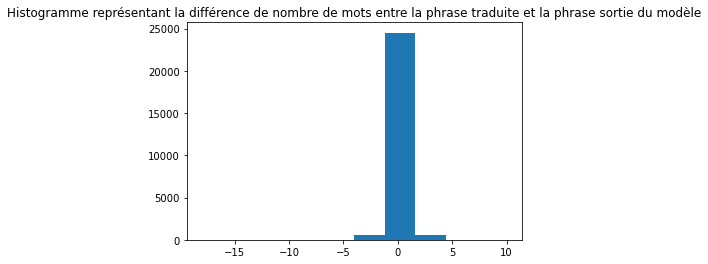

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_results.Différence)
plt.title("Histogramme représentant la différence de nombre de mots entre la phrase traduite et la phrase sortie du modèle"); 

Cet histogramme montre qu'une très grande partie des phrases contiennent le même nombre de mots dans les deux cas.  

### Comparaison des racinisation des mots de chaque des phrases

In [97]:
# Importer stopwords de la classe nltk.corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Initialisation de la liste des mots vides en français puis ajout de certains mots 
stop_words = set(stopwords.words('french'))
stop_words.update(['moins', 'plus', 'a', 'entre', 'ete',',', '.'])

# Intialisation de la racinisation en français 
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
# Application à tout le dataframe 

# Instanciation des listes nécessaires 
racine_cible_tot=[]
racine_cible=[]
racine_mod_tot=[]
racine_mod=[]

# Création d'une colonne 'racine_cible' fournissant la liste des racines des mots des phrases de la colonne cible 
for sentence in df_results['Phrase_traduite']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        if mot not in stop_words: 
        # racinisation des mots 
            racine_cible.append(stemmer.stem(mot))
    racine_cible_tot.append(racine_cible)
    racine_cible=[]
    
df_results['racine_cible']=racine_cible_tot

# rajout des guillemets 
df_results['racine_cible'] = [[f'"{j}"' for j in i] for i in df_results['racine_cible']]


# Création d'une colonne 'racine_mod' fournissant la liste des racines des mots des phrases de la colonne prédite par le modèle  
for sentence in df_results['Sortie_modele']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        if mot not in stop_words: 
        # racinisation des mots 
            racine_mod.append(stemmer.stem(mot))
    racine_mod_tot.append(racine_mod)
    racine_mod=[]

df_results['racine_mod']=racine_mod_tot

# rajout des guillemets 
df_results['racine_mod'] = [[f'"{j}"' for j in i] for i in df_results['racine_mod']]

df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,nb_words_cible,nb_words_mod,Différence,racine_cible,racine_mod
0,"<start> the grapefruit is my favorite fruit ,...","le pamplemousse est mon fruit prefere , mais...","le pamplemousse est mon fruit prefere , mais l...",14,14,0,"[""pamplemouss"", ""fruit"", ""prefer"", ""orang"", ""f...","[""pamplemouss"", ""fruit"", ""prefer"", ""orang"", ""f..."
1,"<start> china is usually hot during summer , ...","chine est generalement chaud pendant l ete ,...","chine est generalement chaud pendant l ete , e...",16,16,0,"[""chin"", ""general"", ""chaud"", ""pend"", ""jam"", ""a...","[""chin"", ""general"", ""chaud"", ""pend"", ""jam"", ""a..."
2,"<start> your favorite fruit is the lemon , bu...","votre fruit prefere est le citron , mais leu...","votre fruit prefere est le citron , mais leur ...",14,14,0,"[""fruit"", ""prefer"", ""citron"", ""prefer"", ""raisin""]","[""fruit"", ""prefer"", ""citron"", ""favor"", ""raisin""]"
3,<start> her favorite fruit is the strawberry ...,"son fruit prefere est la fraise , mais votre...","son fruit prefere est la fraise , mais votre f...",14,14,0,"[""fruit"", ""prefer"", ""frais"", ""favor"", ""banan""]","[""fruit"", ""prefer"", ""frais"", ""favor"", ""banan""]"
4,<start> the united states is usually mild dur...,les etats unis est generalement doux pendant...,les etats unis est generalement doux pendant l...,18,18,0,"[""etat"", ""unis"", ""general"", ""doux"", ""pend"", ""h...","[""etat"", ""unis"", ""general"", ""doux"", ""pend"", ""h..."


### Etablissement des scores 

Nous avons crée deux scores permettant de calculer un score total par la moyenne des deux premiers. 

Le premier score correspond au ratio du nombre de racines en commun sur le nombre de racines des phrases cibles. 

Le second score correspond à un calcul lié au nombre de mots d'écart entre les phrases traduites et les phrases sorties du modèle. Pour une phrase sans mot d'écart, le score sera de 1 et ce score diminue avec l'augmentation du nombre de mots d'écart. 

In [101]:
# Création d'une colonne "comparaison racine" fournissant le ratio nombre de racines en commun / nombre de racines des phrases cibles 
score=[]
for i in range(df_results.shape[0]):
    score.append(len(set(df_results.iloc[i,6]) & set(df_results.iloc[i,7]))/len(df_results.iloc[i,6]))
    
df_results['score_racine']=score

df_results['score_diff']= 1-abs(df_results['Différence'])/18

df_results['score_tot']=(df_results['score_diff']+ df_results['score_racine'])/2

df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,nb_words_cible,nb_words_mod,Différence,racine_cible,racine_mod,score_racine,score_diff,score_tot
0,"<start> the grapefruit is my favorite fruit ,...","le pamplemousse est mon fruit prefere , mais...","le pamplemousse est mon fruit prefere , mais l...",14,14,0,"[""pamplemouss"", ""fruit"", ""prefer"", ""orang"", ""f...","[""pamplemouss"", ""fruit"", ""prefer"", ""orang"", ""f...",1.000000,1.0,1.000000
1,"<start> china is usually hot during summer , ...","chine est generalement chaud pendant l ete ,...","chine est generalement chaud pendant l ete , e...",16,16,0,"[""chin"", ""general"", ""chaud"", ""pend"", ""jam"", ""a...","[""chin"", ""general"", ""chaud"", ""pend"", ""jam"", ""a...",1.000000,1.0,1.000000
2,"<start> your favorite fruit is the lemon , bu...","votre fruit prefere est le citron , mais leu...","votre fruit prefere est le citron , mais leur ...",14,14,0,"[""fruit"", ""prefer"", ""citron"", ""prefer"", ""raisin""]","[""fruit"", ""prefer"", ""citron"", ""favor"", ""raisin""]",0.800000,1.0,0.900000
3,<start> her favorite fruit is the strawberry ...,"son fruit prefere est la fraise , mais votre...","son fruit prefere est la fraise , mais votre f...",14,14,0,"[""fruit"", ""prefer"", ""frais"", ""favor"", ""banan""]","[""fruit"", ""prefer"", ""frais"", ""favor"", ""banan""]",1.000000,1.0,1.000000
4,<start> the united states is usually mild dur...,les etats unis est generalement doux pendant...,les etats unis est generalement doux pendant l...,18,18,0,"[""etat"", ""unis"", ""general"", ""doux"", ""pend"", ""h...","[""etat"", ""unis"", ""general"", ""doux"", ""pend"", ""h...",0.888889,1.0,0.944444


In [102]:
# Calcul de la moyenne du score_tot

print("moyenne du score_tot", df_results['score_tot'].mean())

moyenne du score_tot 0.9528791844459281


Cette moyenne est très élevée car le modèle est sur entrainé (130 000 phrases pour très peu de mots). Les phrases du dataset sont également toujours similaires structurellement. 

Ainsi, le modèle fonctionne très bien sur les échantillons de test même si on peut constater certaines aberrations (correspond au moins bon score). 

Exemple de phrases mal traduites : 

1/ mauvaises associations 
1.1
"paris est pluvieux au printemps" -> "new jersey est pluvieux au printemps , les etats unis au chaud au printemps , les etats unis au chaud au printemps , les"

pourtant paris a été bien traduit ici : 
"paris est agreable au mois d octobre , et il est jamais merveilleux en fevrier" -> "paris est agreable au mois d octobre , et il est jamais merveilleux en fevrier ."

il a dû associer "est pluvieux au printemps" à "new jersey" et à "les etats unis au chaud au printemps , les etats unis au chaud au printemps , les"

1.2
"comment etait le temps dans le new jersey l hiver dernier ?" -> "vous alle a l epicerie ?"

1.3
"comment etait votre visite au new jersey en juin dernier ?" -> "comment aller en france ?"


2/ répétition 
"il veut aller en inde" -> "il est alle en inde en inde en inde en inde en inde en inde en inde en inde en inde en inde en"

Nous pensons que les répétions sont dues à l'approche greedy. 

3/ mauvaises associations + répétition 
"voudrait il aller la tour eiffel ? " - > "vous a conduit votre visite a conduit votre visite a conduit votre visite a conduit votre visite a conduit votre visite a conduit votre"

4/ mauvaises traductions incomprehensibles 

Ligne 11682: " <start> china is mild during september , but it is sometimes snowy in march . <end>"," <start> chine est doux au mois de septembre , mais il est parfois enneigee en mars . <end>","chine est doux au mois de septembre , mais il est parfois neigeux en mars ."

Ligne 18879: <start> china is mild during september . <end>, <start> chine est doux au mois de septembre . <end>,"ils n aimons les etats unis est doux au mois de septembre , les mangues et en chine est doux au mois de septembre"

Enfin, lorsque l'on essaye d'autres phrases (mêmes très simples) hors du dataset, les résultats sont très mauvais. 

Exemples : 
"united states is rainy" -> "il est pluvieux en espagnol"
"the united states is rainy" -> "il n'aime pas les raisons"

Le modèle semble plus performant que dans les itérations précédentes. 

Il est toutefois difficile d'estimer si le modèle serait réellement performant avec un jeu d'entraînement plus diversifié. 